In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [20]:
# Load and prepare the data
def load_data(file_path):
    data = pd.read_csv(file_path)
    data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%d %H:%M:%S')

    # Remove/filter out weekends
    data = data[data['Time'].dt.dayofweek < 5]  # 0-4 corresponds to Monday-Friday

    data = data[-2000:]

    # Assuming columns 'feature1', 'feature2', ..., 'featureN', and 'target'
    time = data['Time']
    X = data[['Open','High', 'Low']]  #features
    Y = data['Close']                #target

    return X, Y, time


# Define the Linear Regression model
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            # Calculate predictions
            y_pred = np.dot(X, self.weights) + self.bias

            # Compute gradients
            dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / num_samples) * np.sum(y_pred - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


# Trade Simulation and Model Performance

In [22]:
# Simulate trades and evaluate performance
def simulate_trades(time_test, y_test, y_pred_test, X_test):
    position_open = False
    position_type = None
    entry_price = 0
    cumulative_pips = 0

    for i in range(len(y_pred_test)):
        if not position_open:  # No position open
            if y_pred_test[i] > X_test[i][0]:  # Long position signal
                position_open = True
                position_type = 'long'
                entry_price = y_test.values[i]
            elif y_pred_test[i] < X_test[i][0]:  # Short position signal
                position_open = True
                position_type = 'short'
                entry_price = y_test.values[i]

        else:  # Position is open# Trade Simulation and Model Performance

            if position_type == 'long':
                if y_test.values[i] >= entry_price + 0.0030:  # Take profit (30 pips)
                    cumulative_pips += 30
                    position_open = False
                elif y_test.values[i] <= entry_price - 0.0010:  # Stop loss (10 pips)# Trade Simulation and Model Performance

                    cumulative_pips -= 10
                    position_open = False

            elif position_type == 'short':
                if y_test.values[i] <= entry_price - 0.0030:  # Take profit (30 pips)
                    cumulative_pips += 30
                    position_open = False
                elif y_test.values[i] >= entry_price + 0.0010:  # Stop loss (10 pips)
                    cumulative_pips -= 10
                    position_open = False

    return cumulative_pips



# Trading strategy and Signal Generation

          Open     High      Low
97949  1.06606  1.06608  1.06439
97950  1.06468  1.06591  1.06460
97951  1.06510  1.06556  1.06313
97952  1.06384  1.06438  1.06309
97953  1.06429  1.06463  1.06226
Training MSE: 2.2784879976205948e-07
Test MSE: 2.3199846202094272e-07
Cumulative Pips Gained/Lost: 200


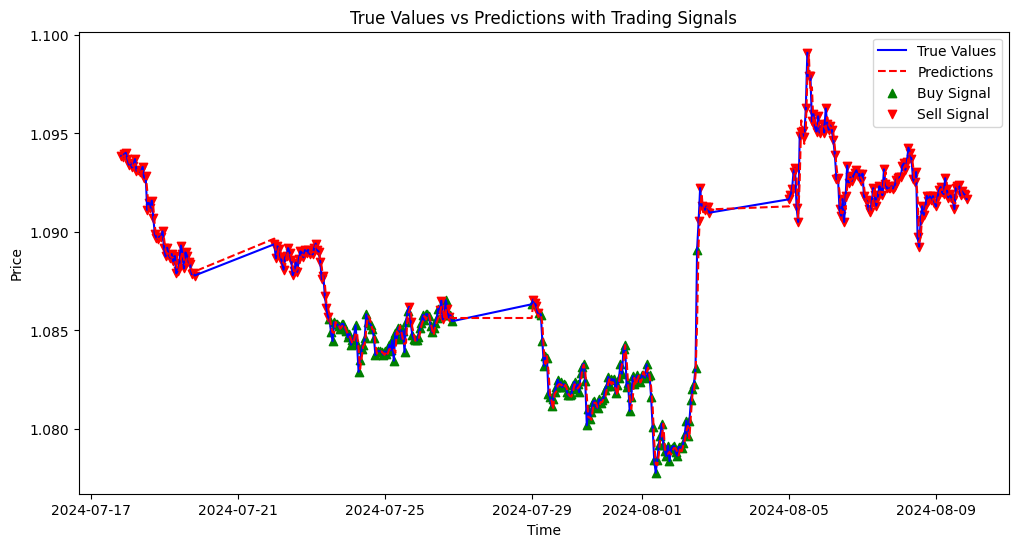

In [23]:
# Main function to run the model
def main():
    # Load data
    file_path = './Data/EURUSD_H1.csv'  # Replace with your CSV file path
    X, y, time = load_data(file_path)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test, time_train, time_test = train_test_split(X, y, time,  test_size=0.2, random_state=42, shuffle=False)

    print(X_train.head())

   # Standardize features - unless volume added, not needed
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    # Initialize and train the model
    model = LinearRegression(learning_rate=0.01, n_iterations=1000)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Evaluate the model
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)

    print(f'Training MSE: {train_mse}')
    print(f'Test MSE: {test_mse}')

   # Initialize lists to store signals
    buy_signals = []
    sell_signals = []
    entry_prices = []

    # Prediction to be based on the previs time step closing/openinng price
    for i in range(len(y_pred_test)):  
        if y_pred_test[i] > X_test[i][0]:  # Predicted close > open (long position signal)
            buy_signals.append((time_test.values[i], y_test.values[i]))  # Save time and price
            sell_signals.append((np.nan, np.nan))  # No sell signal
            entry_prices.append(y_test.values[i])  # Store entry price for long position
        elif y_pred_test[i] < X_test[i][0]:  # Predicted close < open (short position signal)
            sell_signals.append((time_test.values[i], y_test.values[i]))  # Save time and price
            buy_signals.append((np.nan, np.nan))  # No buy signal
            entry_prices.append(y_test.values[i])  # Store entry price for short position
        else:
            buy_signals.append((np.nan, np.nan))  # No signal
            sell_signals.append((np.nan, np.nan))  # No signal
            entry_prices.append(np.nan)  # No entry price

    # Separate time and price for plotting
    buy_times = [signal[0] for signal in buy_signals if not np.isnan(signal[0])]
    buy_prices = [signal[1] for signal in buy_signals if not np.isnan(signal[1])]
    sell_times = [signal[0] for signal in sell_signals if not np.isnan(signal[0])]
    sell_prices = [signal[1] for signal in sell_signals if not np.isnan(signal[1])]

    # Simulate trades and evaluate performance
    cumulative_pips = simulate_trades(time_test, y_test, y_pred_test, X_test)
    print(f'Cumulative Pips Gained/Lost: {cumulative_pips}')

    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(time_test.values, y_test, color='blue', label='True Values')
    plt.plot(time_test.values, y_pred_test, color='red', linestyle='--', label='Predictions')
    plt.scatter(buy_times, buy_prices, marker='^', color='green', label='Buy Signal', alpha=1)
    plt.scatter(sell_times, sell_prices, marker='v', color='red', label='Sell Signal', alpha=1)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('True Values vs Predictions with Trading Signals')
    plt.legend()
    plt.show()


if __name__ == '__main__':
    main()
